In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
#from scipy.optimize import minimize
#from scipy import optimize
#from jax.scipy.optimize import minimize
#from jax.scipy import optimize
#from scipy.linalg import circulant
#from scipy import fft
from joblib import Parallel, delayed
#import torch
#from cycler import cycler
#import torchvision
import cProfile
#from scipy import special
#from scipy.linalg import qr
#from scipy import sparse
import pickle 
import os


import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [10]:
def log_downsample_indices(total_points, num_points=1000):
    """
    Generate logarithmically spaced indices for downsampling.
    The indices are computed in the range [1, total_points] then converted to zero-indexed values.
    """
    indices = np.unique(np.round(np.geomspace(1, total_points, num=num_points)).astype(int)) - 1
    return indices

class TeacherStudentLearning:
    def __init__(self, input_dim, teacher_size, student_size, teacher_params, student_params_ini):
        self.input_dim = input_dim
        self.teacher_size = teacher_size
        self.student_size = student_size
        
        self.teacher_params = teacher_params.copy()
        self.student_params = student_params_ini.copy()
        
        # Initialize batch normalization parameters
        self.student_params['gamma1'] = np.ones(self.student_size)/2
        self.student_params['beta1'] = np.zeros(self.student_size)
        self.student_params['gamma2'] = np.ones(1)/2
        self.student_params['beta2'] = np.zeros(1)
        
        # Initialize batch normalization parameters
        self.teacher_params['gamma1'] = np.ones(self.teacher_size)/2
        self.teacher_params['beta1'] = np.zeros(self.teacher_size)
        self.teacher_params['gamma2'] = np.ones(1)/2
        self.teacher_params['beta2'] = np.zeros(1)



    def phi(self, x, nonlinearity):
        if nonlinearity == 'lin':
            return x
        elif nonlinearity == 'tanh':
            return np.tanh(x)
        elif nonlinearity == 'relu':
            return np.clip(x, a_min=0, a_max=None)
        elif nonlinearity == 'sigmoid':
            return 1/(1+np.exp(-x))
        else:
            raise ValueError(f"Unknown nonlinearity: {nonlinearity}")

    def phi_p(self, x, nonlinearity):
        if nonlinearity == 'lin':
            return np.full_like(x, 1)
        elif nonlinearity == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif nonlinearity == 'relu':
            return (x > 0) * np.full_like(x, 1)
        elif nonlinearity == 'sigmoid':
            return np.exp(x)/(1+np.exp(x))**2
        else:
            raise ValueError(f"Unknown nonlinearity: {nonlinearity}")

    def ff_pass(self, x, network_params, nonlinearity, batch_norm=True):
        W1, W2 = network_params['W1'], network_params['W2']
        
        if batch_norm:
            a1 = np.dot(W1, x)
            a1_bn = ((a1-a1.mean(axis = -1)[:,None])/(a1.std(axis = -1)[:,None]))*network_params['gamma1'][:,None]+network_params['beta1'][:,None]
            h = self.phi(a1_bn, nonlinearity)
            
            a2 = np.dot(W2, h)
            a2_bn = ((a2-a2.mean(axis = -1)[:,None])/(a2.std(axis = -1)[:,None]))*network_params['gamma2'][:,None]+network_params['beta2'][:,None]
            y = self.phi(a2_bn, nonlinearity)
        else:
            h = self.phi(np.dot(W1, x), nonlinearity)
            y = self.phi(np.dot(W2, h), nonlinearity)
        return y
            

    
    def error(self, input_list, nonlinearity, batch_norm):
        inputs = np.stack(input_list, axis=1)  # Combine inputs for batch processing
        y_hat = self.ff_pass(inputs, self.student_params, nonlinearity, batch_norm)
        y = self.ff_pass(inputs, self.teacher_params, nonlinearity, batch_norm)
        return 0.5 * np.mean((y_hat - y) ** 2)
    
    def learning_update(self, x, B, learning_rate, plasticity, modification_type, nonlinearity, batch_norm, ):
        y_hat = self.ff_pass(x, self.student_params, nonlinearity, batch_norm)
        y = self.ff_pass(x, self.teacher_params, nonlinearity, batch_norm)
        e = y_hat - y
        
        if batch_norm :
            a = np.dot(self.student_params['W1'],  x)
            a = ((a-a.mean(axis = -1)[:,None])/(a.std(axis = -1)[:,None]))*self.student_params['gamma1'][:,None]+self.student_params['beta1'][:,None]
            h = self.phi(a, nonlinearity)   
        else:
            a = self.student_params['W1'] @ x
            h = self.phi(a, nonlinearity)
        
        
        if plasticity == 'GD':
            da2 = e
            da1 = (self.student_params['W2'].T @ da2) * self.phi_p(a, nonlinearity)
        elif plasticity == 'Hebb_DFA_inh_w_GD_feedback':
            da2 = e
            da1 = (self.student_params['W2'].T @ da2) * self.phi_p(a, nonlinearity)
        elif plasticity == 'DFA':
            da2 = e
            da1 = (B @ da2) * self.phi_p(a, nonlinearity)
        else:
            raise ValueError(f"Unknown plasticity: {plasticity}")

        if modification_type == 'col':
        # Compute weight updates by summing over the batch dimension (axis=1)
            dWs2 = -learning_rate * (da2 @ h.T @ self.student_params['D2']) / da2.shape[1]
            dWs1 = -learning_rate * (da1 @ x.T @ self.student_params['D1']) / da1.shape[1]
        
        elif modification_type == 'row':
        # Update on row instead
            dWs2 = -learning_rate * (self.student_params['D2'] @ da2 @ h.T) / da2.shape[1]
            dWs1 = -learning_rate * ( self.student_params['D1'] @ da1 @ x.T) / da1.shape[1]
        
        return dWs1, dWs2
    
    def _normalize_weights(self, weights):
        # Normalize each row of the weight matrix to have a unit norm
        norms = np.linalg.norm(weights, axis=1, keepdims=True)  # L2 norm of each row
        return weights / (norms + 1e-8)  # Add epsilon to prevent division by zero



    def learning_simu_batch(self, input_list, input_test_list, batch_size, nb_epochs, B, learning_rate, plasticity, modification_type, nonlinearity, normalize_weights=True, batch_norm=True,  test_set=False):
        """
        Simulates the learning process with batch updates.

        Args:
            input_list: List of input samples.
            batch_size: Size of each batch.
            nb_epochs: Number of training epochs.
            B: Feedback alignment matrix.
            learning_rate: Learning rate.
            plasticity: Type of plasticity ('GD' or 'DFA').
            nonlinearity: Nonlinearity function.
            normalize_weights: Whether to normalize weights after each batch update.

        Returns:
            Ws1_hist: History of W1 updates.
            Ws2_hist: History of W2 updates.
            error_hist: History of error.
        """
        inputs = np.stack(input_list, axis=1)  # Stack inputs into a single matrix (shape: input_dim x total_samples)
        total_samples = inputs.shape[1]

        Ws1_hist = [self.student_params['W1'].copy()]
        Ws2_hist = [self.student_params['W2'].copy()]
        error_hist = [self.error(input_list[:batch_size], nonlinearity, batch_norm)]
        if test_set:
            test_error_hist = [self.error(input_test_list, nonlinearity, batch_norm)]
        else:
            test_error_hist = np.zeros_like(np.array(error_hist))

            
            
        log_indices = log_downsample_indices(nb_epochs, num_points=100)
        ind = 1
        
        for epoch in range(nb_epochs):
            # Shuffle the data at the start of each epoch
            indices = np.random.permutation(total_samples)
            shuffled_inputs = inputs[:, indices]

            for start_idx in range(0, total_samples, batch_size):
                # Define batch range
                end_idx = min(start_idx + batch_size, total_samples)
                batch = shuffled_inputs[:, start_idx:end_idx]
                
                dWs1_avg, dWs2_avg = self.learning_update(batch, B, learning_rate, plasticity, modification_type, nonlinearity, batch_norm)

                # Update weights
                self.student_params['W1'] += dWs1_avg
                self.student_params['W2'] += dWs2_avg

                # Enforce weight normalization
                if normalize_weights:
                    self.student_params['W1'] = self._normalize_weights(self.student_params['W1'])
                    self.student_params['W2'] = self._normalize_weights(self.student_params['W2'])

            if epoch == log_indices[ind]:
                # Record history
                Ws1_hist.append(self.student_params['W1'].copy())
                Ws2_hist.append(self.student_params['W2'].copy())

                error_hist.append(self.error(input_list, nonlinearity, batch_norm))  # Evaluate on the first sample of the batch [batch[:, 0]]
                if test_set:
                    test_error_hist.append(self.error(input_test_list, nonlinearity, batch_norm))

                ind+=1


        return np.array(Ws1_hist), np.array(Ws2_hist), np.array(error_hist), np.array(test_error_hist)


    
    def learning_simu(self, input_list, B, learning_rate, plasticity, nonlinearity):
        Ws1_hist = [self.student_params['W1'].copy()]
        Ws2_hist = [self.student_params['W2'].copy()]
        error_hist = [self.error([input_list[0]], nonlinearity)]
        
        for x in input_list:
            dWs1, dWs2 = self.learning_update(x, B, learning_rate, plasticity, nonlinearity)
            self.student_params['W1'] += dWs1
            self.student_params['W2'] += dWs2
            
            Ws1_hist.append(self.student_params['W1'].copy())
            Ws2_hist.append(self.student_params['W2'].copy())
            error_hist.append(self.error([x], nonlinearity))
        
        return np.array(Ws1_hist), np.array(Ws2_hist), np.array(error_hist)

    
    

    
def find_timestep_below_threshold(errors, thresh):
    """
    Find the timestep at which the error gets below a threshold value.

    Parameters:
    errors (numpy.ndarray): Array of error values.
    thresh (float): Threshold value.

    Returns:
    int: The timestep at which the error gets below the threshold, or -1 if it never does.
    """
    # Find the indices where the error is below the threshold
    below_threshold_indices = np.where(errors < thresh)[0]

    # If there are no such indices, return -1
    if below_threshold_indices.size == 0:
        return -1

    # Return the first index where the error is below the threshold
    return below_threshold_indices[0]

In [52]:
label_list = ['GD', 'DFA', 'DFA with inhibitory', 'Hebb DFA inh with GD feedback']
plasticity_list = ['GD', 'DFA', 'DFA', 'Hebb_DFA_inh_w_GD_feedback']



with open('run_tanh_uniform_59.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

params_dic, input_list, input_test_list, Ws1_hist_dic, Ws2_hist_dic, error_hist_dic, test_error_hist_dic = loaded_data


nb_data_points = params_dic['nb_data_points']
nb_test_data_points = params_dic['nb_test_data_points'] 
input_dim = params_dic['input_dim']
teacher_size = params_dic['teacher_size']
student_size = params_dic['student_size']
nb_AH_layer1 = params_dic['nb_AH_layer1']
nb_AH_layer2 = params_dic['nb_AH_layer2']
nb_epochs = params_dic['nb_epochs']
nb_init = params_dic['nb_init']
nonlinearity_list = params_dic['nonlinearity_list']
learning_rate = params_dic['learning_rate']
B_dic =  params_dic['B_dic']

log_indices = log_downsample_indices(nb_epochs, num_points=100)

color_list = ['#790992', '#C65D0A', '#fab16c', '#c385d1']

In [53]:
params_dic

{'nb_data_points': 2000,
 'nb_test_data_points': 100,
 'input_dim': 100,
 'teacher_size': 10,
 'student_size': 10,
 'output_dim': 1,
 'nb_AH_layer1': 0,
 'nb_AH_layer2': 1,
 'nb_epochs': 100000,
 'nb_init': 10,
 'nonlinearity_list': ['tanh', 'tanh', 'tanh', 'tanh'],
 'learning_rate': 0.1,
 'B_dic': {'GD': [array([[-0.31425853],
          [ 0.08396558],
          [-0.09969326],
          [-0.18887093],
          [-0.21899879],
          [ 0.19283101],
          [-0.16644539],
          [ 0.17458365],
          [ 0.30387737],
          [ 0.15393192]]),
   array([[-0.24209194],
          [ 0.18895649],
          [-0.05546793],
          [ 0.15558751],
          [ 0.21497898],
          [ 0.11738326],
          [ 0.19113359],
          [ 0.03663621],
          [ 0.23645272],
          [ 0.27159783]]),
   array([[ 0.30612713],
          [-0.03163426],
          [-0.137931  ],
          [ 0.05208664],
          [-0.15964835],
          [ 0.11396345],
          [ 0.30748076],
          [ 0.12

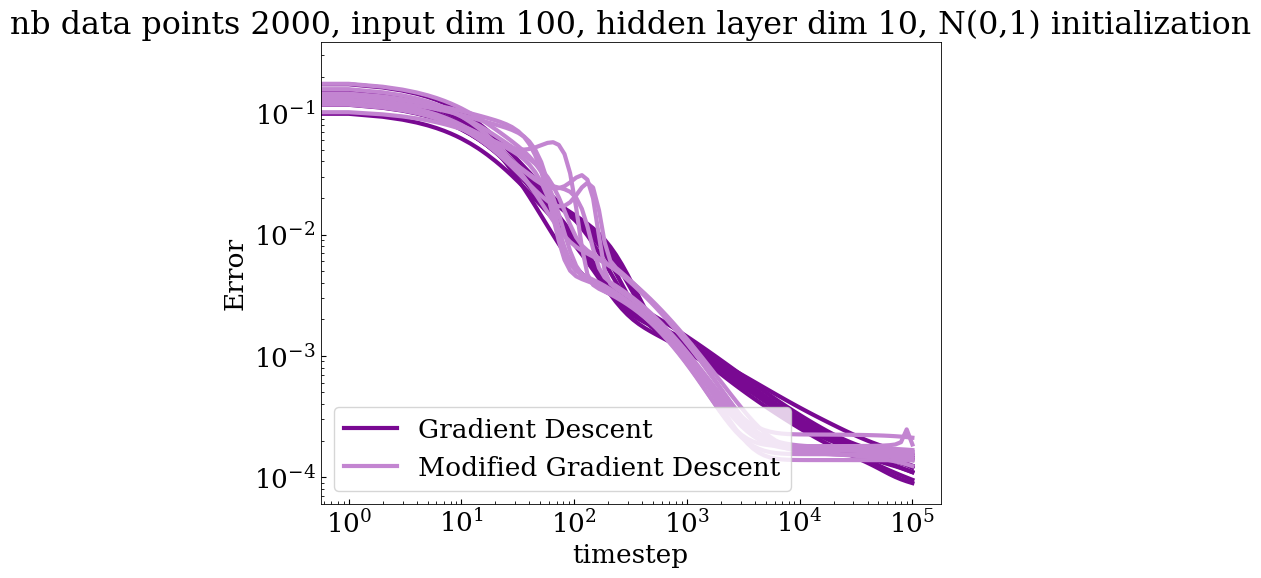

In [54]:

plt.figure(figsize=(8, 6))

for i in range(len(label_list)):
    if i in [0,3]:
        # Plot the first run with a legend entry.
        errors = np.array(error_hist_dic[label_list[i]])[0].round(15)
        plt.plot(log_indices, errors, label=label_list_mod[i], color=color_list[i], alpha=1, linewidth = 3)

        # Plot subsequent runs without legend entries.
        for j in range(1, nb_init):
            errors = np.array(error_hist_dic[label_list[i]])[j].round(15)
            plt.plot(log_indices, errors, color=color_list[i], alpha=1, linewidth = 3)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel('timestep')
plt.legend(loc='lower left')
#plt.ylim((1e-14, 1e4))
plt.title('nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
          % (nb_data_points, input_dim, student_size))

# Save the figure with a lower DPI to further reduce file size
#plt.savefig('loglog_lin_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_N(0,1)_initialization.pdf' % (nb_data_points, input_dim, student_size), dpi=300)
plt.show()

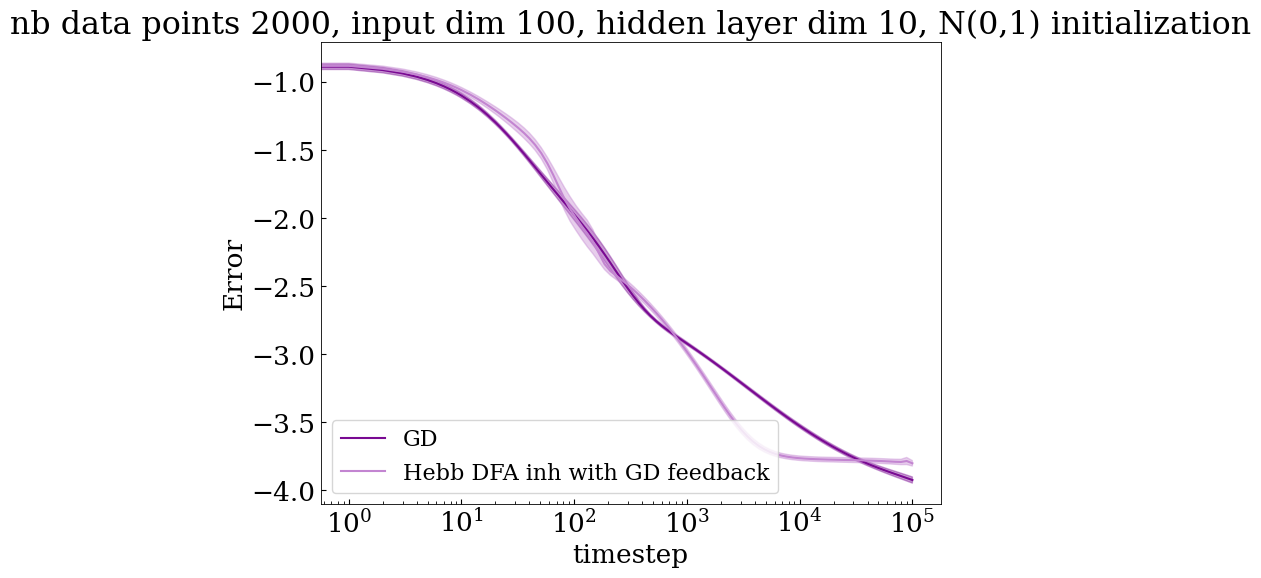

In [55]:


plt.figure(figsize=(8, 6))

for i, label in enumerate(label_list):
    if i in [0,3]:
        # Convert error histories to a numpy array: shape (nb_init, timesteps)
        errors = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)

        # Compute average and SEM across runs (axis 0)
        avg_error = np.mean(errors, axis=0)
        sem_error = np.std(errors, axis=0) / np.sqrt(errors.shape[0])


        # Plot the average error curve
        plt.plot(log_indices, avg_error, label=label, color=color_list[i])
        # Add the shaded region (mean ± SEM)
        plt.fill_between(log_indices, avg_error - sem_error, avg_error + sem_error,
                         color=color_list[i], alpha=0.4)

#plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel('timestep')
plt.legend(fontsize=16, frameon=True, framealpha=0.8)#plt.ylim((1e-14, 1e4))
plt.title('nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
          % (nb_data_points, input_dim, student_size))

# Save with a lower DPI to further reduce file size
#plt.savefig('avg loglog_lin_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_U(0,1)_initialization.pdf' % (nb_data_points, input_dim, student_size), dpi=72)
plt.show()


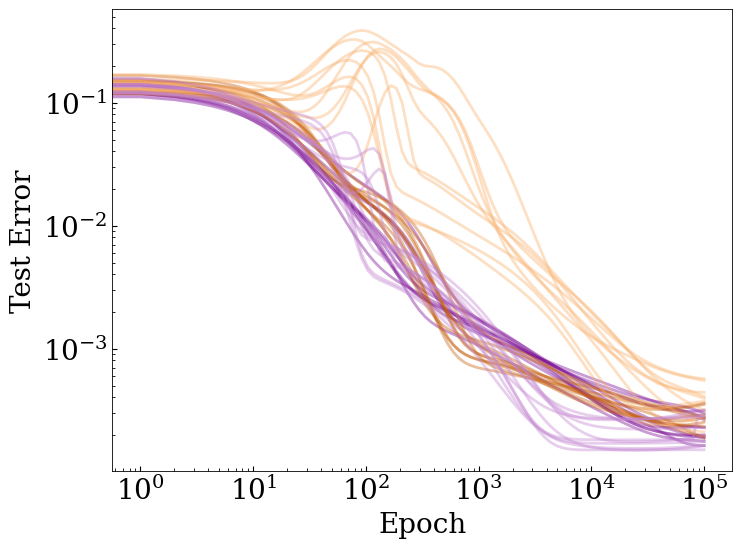

In [56]:

plt.figure(figsize=(8, 6))

for i in range(len(label_list)):
    # Plot the first run with a legend entry.
    errors = np.array(test_error_hist_dic[label_list[i]])[0].round(15)
    plt.plot(log_indices, errors, label=label_list[i], color=color_list[i], alpha=0.4, linewidth = 2)
    
    # Plot subsequent runs without legend entries.
    for j in range(1, nb_init):
        errors = np.array(test_error_hist_dic[label_list[i]])[j].round(15)
        plt.plot(log_indices, errors, color=color_list[i], alpha=0.4, linewidth =2)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Test Error', fontsize=20)
plt.xlabel('Epoch', fontsize = 20)
#plt.legend(loc='lower left')
#plt.ylim((1e-14, 1e4))
#plt.title('nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
#          % (nb_data_points, input_dim, student_size))
plt.tick_params(axis='both', which='major', labelsize=20)
# Save the figure with a lower DPI to further reduce file size
#plt.savefig('tanhlearning_curves_poster_high_data_regime.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [16]:


plt.figure(figsize=(8, 6))

for i, label in enumerate(label_list):
    if i in [0,3]:
        # Convert error histories to a numpy array: shape (nb_init, timesteps)
        test_errors = np.array(test_error_hist_dic[label]).round(15)#np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)

        # Compute average and SEM across runs (axis 0)
        avg_error = np.mean(test_errors, axis=0)
        sem_error = np.std(test_errors, axis=0) / np.sqrt(test_errors.shape[0])

        # Plot the average error curve
        plt.plot(log_indices, avg_error, label=label_list_mod[i], color=color_list[i], linewidth = 3)
        # Add the shaded region (mean ± SEM)
        plt.fill_between(log_indices, avg_error - sem_error, avg_error + sem_error,
                         color=color_list[i], alpha=0.4)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Test error', fontsize = 40)
plt.xlabel('Epoch', fontsize = 40)
plt.legend(loc='lower left')
plt.legend(fontsize=22, frameon=True, framealpha=0.8)
#plt.ylim((1e-14, 1e4))
#plt.title('Test error nb data points %d, input dim %d, hidden layer dim %d, U(0,1) initialization'
#          % (nb_data_points, input_dim, student_size))
plt.tight_layout()
#plt.ylim(0,1e5)
plt.tick_params(axis='both', which='major', labelsize=30)
# Save with a lower DPI to further reduce file size
#plt.savefig('nice-avg_loglog_relu_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_U_initialization.pdf' % (nb_data_points, input_dim, student_size), dpi=300, bbox_inches = 'tight')
#plt.savefig('nice-avg_loglog_relu_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_U_initialization.png' % (nb_data_points, input_dim, student_size), dpi=300,bbox_inches = 'tight')
#plt.savefig('nice-avg_loglog_relu_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_U_initialization.svg' % (nb_data_points, input_dim, student_size), dpi=300,bbox_inches = 'tight')

plt.show()


NameError: name 'label_list_mod' is not defined

<Figure size 800x600 with 0 Axes>

In [17]:
test_errors.shape[0]

10

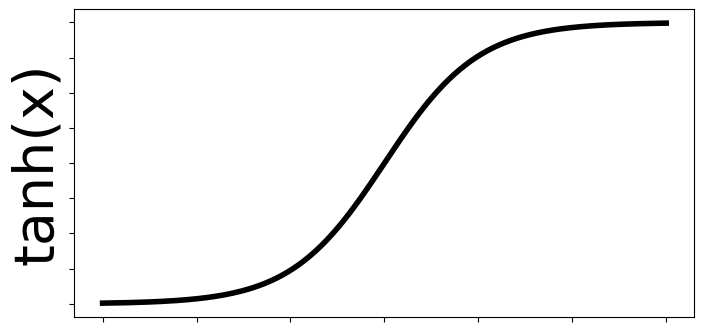

In [18]:
plt.figure(figsize=(8, 4))

x = np.linspace(-3,3, num=200)

plt.plot(x, np.tanh(x), color='k', linewidth = 4)
plt.ylabel('tanh(x)', fontsize = 40)
plt.tick_params(axis='both', which='both', labelsize=0, labelbottom=False, labelleft=False)

#plt.savefig('tanh_fct.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [19]:
def list_pkl_files(directory="."):
    try:
        # List all files and directories in the specified directory
        files_and_dirs = os.listdir(directory)

        # Filter out directories and non-.pkl files, keep only .pkl files
        pkl_files = [f for f in files_and_dirs if os.path.isfile(os.path.join(directory, f)) and f.endswith('.pkl')]

        return pkl_files
    except Exception as e:
        return str(e)

# Example usage
pkl_files = list_pkl_files()
len(pkl_files)

60

In [20]:
pkl_files

['run_tanh_uniform_45.pkl',
 'run_tanh_uniform_51.pkl',
 'run_tanh_uniform_50.pkl',
 'run_tanh_uniform_44.pkl',
 'run_tanh_uniform_52.pkl',
 'run_tanh_uniform_46.pkl',
 'run_tanh_normal_40.pkl',
 'run_tanh_uniform_47.pkl',
 'run_tanh_uniform_53.pkl',
 'run_tanh_uniform_57.pkl',
 'run_tanh_uniform_43.pkl',
 'run_tanh_uniform_42.pkl',
 'run_tanh_uniform_56.pkl',
 'run_tanh_uniform_54.pkl',
 'run_tanh_uniform_55.pkl',
 'run_tanh_uniform_41.pkl',
 'run_lin_normal_8.pkl',
 'run_tanh_normal_34.pkl',
 'run_tanh_normal_35.pkl',
 'run_lin_normal_9.pkl',
 'run_lin_uniform_18.pkl',
 'run_tanh_normal_23.pkl',
 'run_tanh_normal_37.pkl',
 'run_tanh_normal_36.pkl',
 'run_tanh_normal_22.pkl',
 'run_lin_uniform_19.pkl',
 'run_lin_uniform_21.pkl',
 'run_tanh_normal_26.pkl',
 'run_tanh_normal_32.pkl',
 'run_tanh_normal_33.pkl',
 'run_tanh_normal_27.pkl',
 'run_lin_uniform_20.pkl',
 'run_tanh_normal_31.pkl',
 'run_lin_normal_10.pkl',
 'run_tanh_normal_25.pkl',
 'run_tanh_normal_24.pkl',
 'run_tanh_normal_

In [22]:
log_indices = log_downsample_indices(nb_epochs, num_points=100)

nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

filtered_list  = [item for item in pkl_files if item.startswith('run_tanh_uniform')]


#for run_nb in range(33,60):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)
for file in filtered_list:
    with open(file, 'rb') as f:
        loaded_data = pickle.load(f)

    params_dic, input_list, input_test_list, Ws1_hist_dic, Ws2_hist_dic, error_hist_dic, test_error_hist_dic = loaded_data
    
    nb_data_points = params_dic['nb_data_points']
    nb_test_data_points = params_dic['nb_test_data_points'] 
    input_dim = params_dic['input_dim']
    teacher_size = params_dic['teacher_size']
    student_size = params_dic['student_size']
    nb_AH_layer1 = params_dic['nb_AH_layer1']
    nb_AH_layer2 = params_dic['nb_AH_layer2']
    nb_epochs = params_dic['nb_epochs']
    nb_init = params_dic['nb_init']
    nonlinearity_list = params_dic['nonlinearity_list']
    learning_rate = params_dic['learning_rate']

    nb_datpoints_list.append(nb_data_points)
    error_hist_dic_list.append(error_hist_dic)
    test_error_hist_dic_list.append(test_error_hist_dic)
filtered_list

['run_tanh_uniform_45.pkl',
 'run_tanh_uniform_51.pkl',
 'run_tanh_uniform_50.pkl',
 'run_tanh_uniform_44.pkl',
 'run_tanh_uniform_52.pkl',
 'run_tanh_uniform_46.pkl',
 'run_tanh_uniform_47.pkl',
 'run_tanh_uniform_53.pkl',
 'run_tanh_uniform_57.pkl',
 'run_tanh_uniform_43.pkl',
 'run_tanh_uniform_42.pkl',
 'run_tanh_uniform_56.pkl',
 'run_tanh_uniform_54.pkl',
 'run_tanh_uniform_55.pkl',
 'run_tanh_uniform_41.pkl',
 'run_tanh_uniform_58.pkl',
 'run_tanh_uniform_59.pkl',
 'run_tanh_uniform_49.pkl',
 'run_tanh_uniform_48.pkl']

In [23]:
nb_datpoints_list

[260,
 500,
 440,
 220,
 600,
 300,
 340,
 800,
 1600,
 180,
 140,
 1400,
 1000,
 1200,
 100,
 1800,
 2000,
 420,
 380]

In [24]:
lenlist = len(nb_datpoints_list)
order = np.argsort(nb_datpoints_list)

err_nbdat_mean = np.zeros((4,lenlist))
err_nbdat_std = np.zeros((4,lenlist))

test_err_nbdat_mean = np.zeros((4,lenlist))
test_err_nbdat_std = np.zeros((4,lenlist))

ts_train_nbdat_mean = np.zeros((4,lenlist))
ts_train_nbdat_std = np.zeros((4,lenlist))

ts_test_nbdat_mean = np.zeros((4,lenlist))
ts_test_nbdat_std = np.zeros((4,lenlist))

train_besterror_mean = np.zeros((4,lenlist))
train_besterror_std = np.zeros((4,lenlist))

test_besterror_mean = np.zeros((4,lenlist))
test_besterror_std = np.zeros((4,lenlist))

ts_test_nbdat_all = np.zeros((4,lenlist, nb_init))


timestep = -1
log_indices[timestep]

99999

In [25]:
errors = np.log10(np.array(error_hist_dic_list[0]['GD']).round(15)+1e-15)

thresh = -3#-6#-3 #-20

ts_blw_thr = find_timestep_below_threshold(errors[0], thresh = thresh)

for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        ts_train_list = log_indices[np.array([find_timestep_below_threshold(error[k], thresh = thresh) for k in range(error.shape[0])])]
        
        ts_train_nbdat_mean[j,i] = ts_train_list.mean()
        ts_train_nbdat_std[j,i] = ts_train_list.std()
        
    
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        ts_test_list = log_indices[np.array([find_timestep_below_threshold(test_error[k], thresh = thresh) for k in range(test_error.shape[0])])]
        
        ts_test_nbdat_mean[j,i] = ts_test_list.mean()
        ts_test_nbdat_std[j,i] = ts_test_list.std()
        
        
        ts_test_nbdat_all[j,i] = np.asarray(ts_test_list)
        
        
        train_besterror_mean[j,i] = error.min(axis = 1).mean()
        train_besterror_std[j,i] = error.min(axis = 1).std()
        
        test_besterror_mean[j,i] = test_error.min(axis = 1).mean()
        test_besterror_std[j,i] = test_error.min(axis = 1).std()


In [26]:
for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        err_mean = error[:,timestep].mean()
        err_std = error[:,timestep].std()

        err_nbdat_mean[j,i] = err_mean
        err_nbdat_std[j,i] = err_std
        
        
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        test_err_mean = test_error[:,timestep].mean()
        test_err_std = test_error[:,timestep].std()

        test_err_nbdat_mean[j,i] = test_err_mean
        test_err_nbdat_std[j,i] = test_err_std

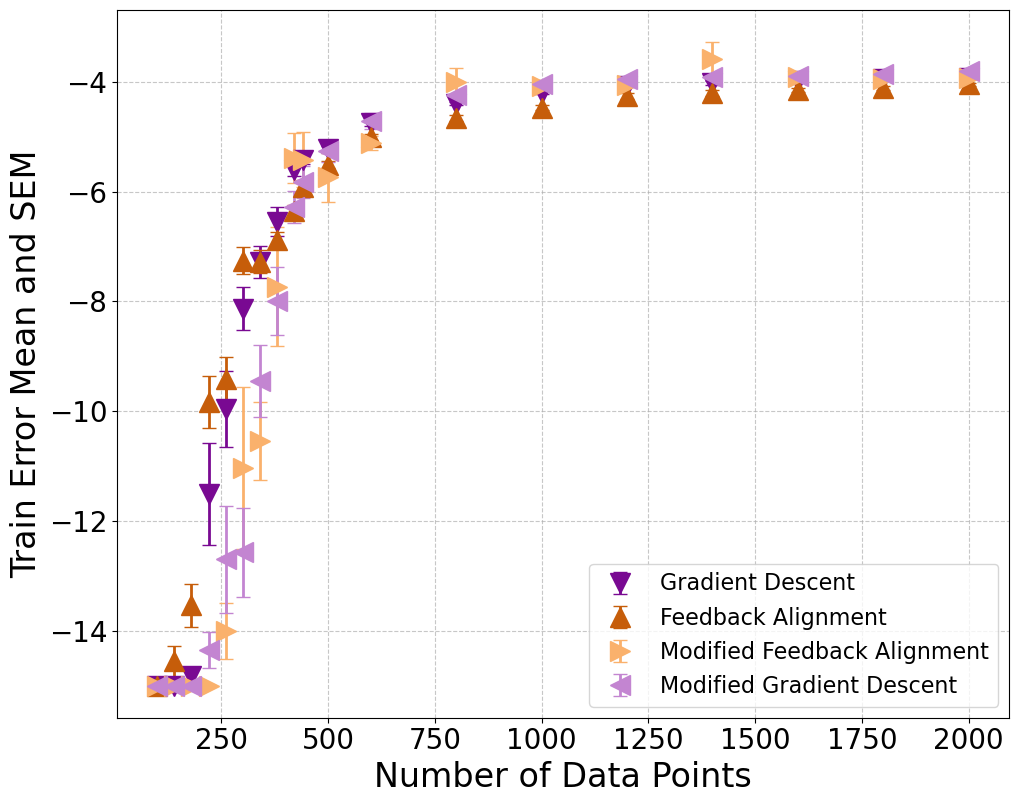

In [27]:
label_list_mod = ['Gradient Descent', 'Feedback Alignment', 'Modified Feedback Alignment', 'Modified Gradient Descent']
fmt_list = ['v','^','>','<']

# Assuming label_list, nb_datpoints_list, err_nbdat_mean, err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

for i, label in enumerate(label_list_mod):
    plt.errorbar(nb_datpoints_list, err_nbdat_mean[i, :], yerr=err_nbdat_std[i, :] / np.sqrt(error.shape[0]),
                 fmt=fmt_list[i], color=color_list[i], label=label, capsize=5, elinewidth=2, markersize=14)
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth =2)

plt.ylabel('Train Error Mean and SEM', fontsize=24)
plt.xlabel('Number of Data Points', fontsize=24)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
plt.legend(fontsize=16, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.ylim(-36,2)
plt.tick_params(axis='both', which='major', labelsize=20)
# Uncomment the following line if you want to save the figure
#plt.savefig('scientific_plot_tanh.pdf', dpi=300, bbox_inches='tight')

plt.show()

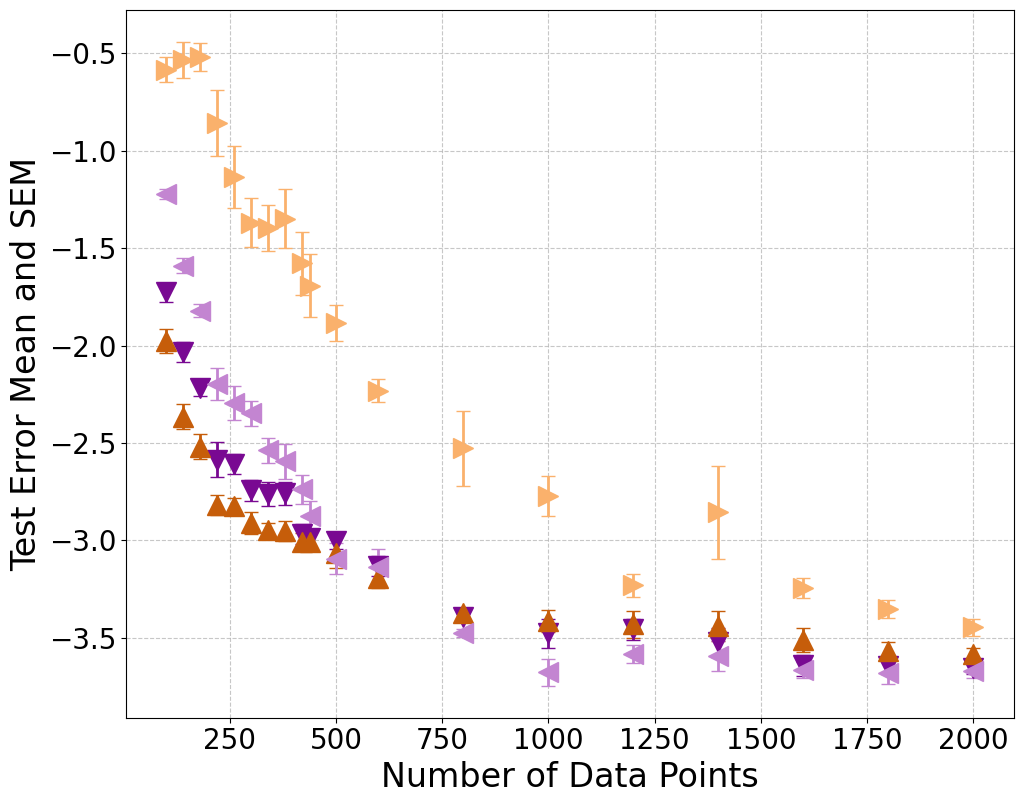

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming label_list, nb_datpoints_list, test_err_nbdat_mean, test_err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

for i, label in enumerate(label_list_mod):
    plt.errorbar(nb_datpoints_list, test_err_nbdat_mean[i, :], yerr=test_err_nbdat_std[i, :] / np.sqrt(error.shape[0]),
                 fmt=fmt_list[i], color=color_list[i], label=label, capsize=5, elinewidth=2, markersize=14)
    
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth = 2)

plt.ylabel('Test Error Mean and SEM', fontsize=24)
plt.xlabel('Number of Data Points', fontsize=24)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
#plt.legend(fontsize=16, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=20)


# Uncomment the following line if you want to save the figure
#plt.savefig('scientific_plot_test_error_tanh.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [29]:
ts_train_nbdat_mean

array([[  689.8,   852.8,   779.1,   635.3,   937.7,   661. ,   698.9,
          979.8,  1374.3,   487.1,   418.3,  1316.6,  1108.5,  1295.2,
          310.2,  1374.4,  1464.4,   782.7,   778. ],
       [  742.3,   799. ,   800.1,   772.8,   785.5,   911.6,   723.7,
          815.7,   924.5,   797.3,   673.3,  1049.9,   801.2,  1021. ,
          557.4,  1003.1,   886.6,   788.7,   768.7],
       [ 5796.8, 10070. , 24209.6,  8629.3,  5467.6,  8859.7,  9919.4,
        25442.2, 10789.5,  8662. ,  6170.4, 26174.7, 17013.7,  7458.4,
         2662.2,  8835.2,  7368.8, 24041. , 14011. ],
       [  435.3,   879.5,   799. ,   434. ,   939.8,   617. ,   614.6,
         1128.9,  1063.6,   432.3,   315.3,  1128.8,   940.3,  1179.9,
          307.5,  1130.8,  1108.5,   835.7,   707.3]])

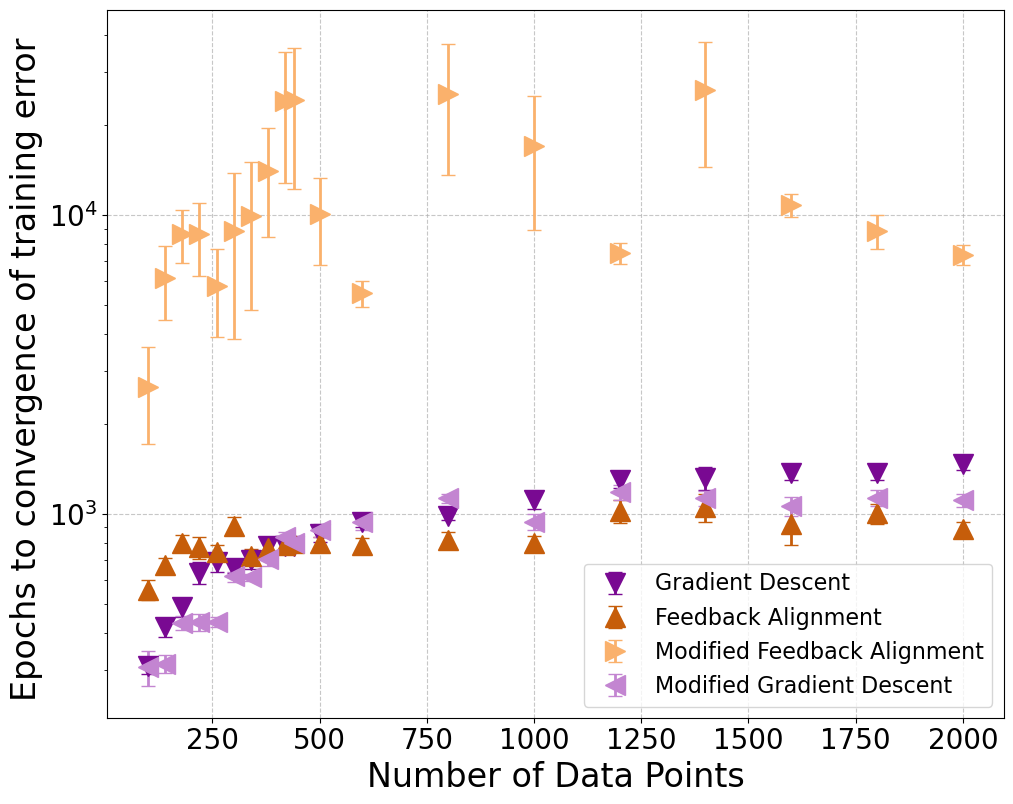

In [30]:
label_list_mod = ['Gradient Descent', 'Feedback Alignment', 'Modified Feedback Alignment', 'Modified Gradient Descent']
fmt_list = ['v','^','>','<']

# Assuming label_list, nb_datpoints_list, err_nbdat_mean, err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

for i, label in enumerate(label_list_mod):
    plt.errorbar(nb_datpoints_list, ts_train_nbdat_mean[i, :], yerr=ts_train_nbdat_std[i, :] / np.sqrt(nb_init),
                 fmt=fmt_list[i], color=color_list[i], label=label, capsize=5, elinewidth=2, markersize=14)
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth =2)

plt.yscale('log')

plt.ylabel('Epochs to convergence of training error ', fontsize=24)
plt.xlabel('Number of Data Points', fontsize=24)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
plt.legend(fontsize=16, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.ylim(-36,2)
plt.tick_params(axis='both', which='major', labelsize=20)
# Uncomment the following line if you want to save the figure
#plt.savefig('tanh_train_tocv_sini.pdf', dpi=300, bbox_inches='tight')

plt.show()

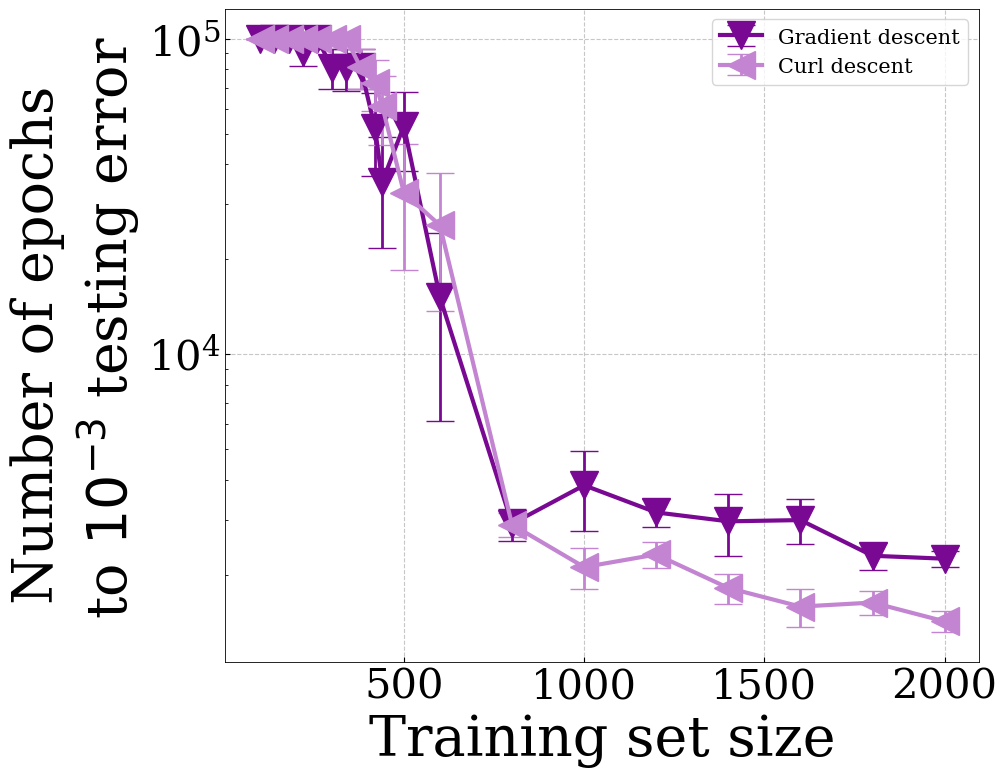

In [32]:
label_list_mod = ['Gradient descent', 'Feedback Alignment', 'Feedback Alignment + Curl descent', 'Curl descent']
fmt_list = ['v','^','>','<']

# Assuming label_list, nb_datpoints_list, err_nbdat_mean, err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

from matplotlib import rcParams, colors as mcolors

rcParams.update({
    "font.family": "serif",
    "font.size": 19,
    "axes.linewidth": 0.6,
    "axes.spines.right": True,
    "axes.spines.top": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

for i, label in enumerate(label_list_mod):
    if i in [0,3]:
        plt.errorbar(np.asarray(nb_datpoints_list)[order], ts_test_nbdat_mean[i, order], yerr=ts_test_nbdat_std[i, order] / np.sqrt(nb_init),
                     fmt='-'+fmt_list[i], color=color_list[i], label=label, capsize=10, elinewidth=2, markersize=20, linewidth = 3)
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth =2)

plt.yscale('log')

plt.ylabel('Number of epochs \n to $10^{%d}$ testing error'%thresh, fontsize=40)
plt.xlabel('Training set size', fontsize=40)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
plt.legend(fontsize=15, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.ylim(0,1e5)
plt.tick_params(axis='both', which='major', labelsize=30)
# Uncomment the following line if you want to save the figure
#plt.savefig('tanh_test_to_cv_sini_nonnormalized.pdf', dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig('tanh_test_to_cv_sini_nonnormalized.png', dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig('tanh_test_to_cv_sini_nonnormalized.svg', dpi=300, bbox_inches='tight', transparent=True)


plt.show()

In [38]:
ts_test_nbdat_all[0, :, :].shape

(19, 10)

In [43]:
from scipy import stats

ts_test_all_gd = ts_test_nbdat_all[:,order,:][0, -6:, :]
ts_test_all_cd = ts_test_nbdat_all[:,order,:][3, -6:, :]

print(stats.ttest_rel(ts_test_all_gd.ravel(), ts_test_all_cd.ravel()))

TtestResult(statistic=5.043171954944638, pvalue=4.655257761807084e-06, df=59)


In [44]:
for i in range(len(ts_test_all_gd)):
    print(nb_datpoints_list[i], stats.ttest_rel(ts_test_all_gd[i].ravel(), ts_test_all_cd[i].ravel()))

260 TtestResult(statistic=1.7442575654324308, pvalue=0.11507845665411821, df=9)
500 TtestResult(statistic=2.806296774567141, pvalue=0.020500677130198756, df=9)
440 TtestResult(statistic=2.1221339006975497, pvalue=0.0628194167999488, df=9)
220 TtestResult(statistic=2.3318128646055625, pvalue=0.044614485450121776, df=9)
600 TtestResult(statistic=3.234609509658339, pvalue=0.010246718730518014, df=9)
300 TtestResult(statistic=6.755442717703893, pvalue=8.31348476357366e-05, df=9)


In [45]:
len(ts_test_all_gd)

6

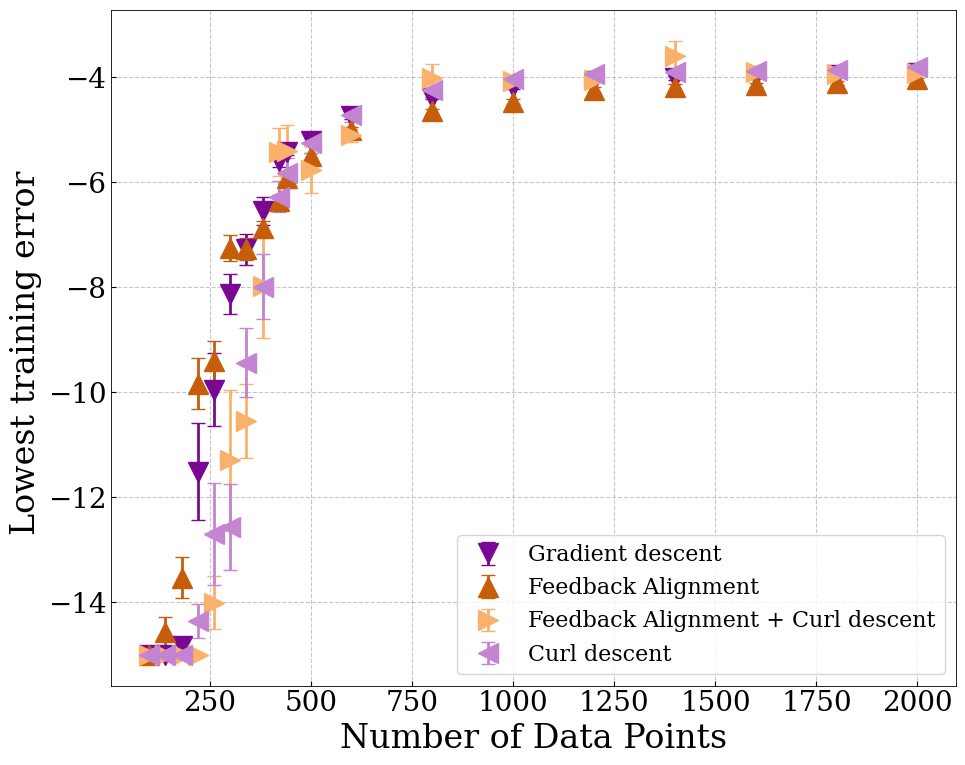

In [46]:
#label_list_mod = ['Gradient Descent', 'Feedback Alignment', 'Modified Feedback Alignment', 'Modified Gradient Descent']
fmt_list = ['v','^','>','<']

# Assuming label_list, nb_datpoints_list, err_nbdat_mean, err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

for i, label in enumerate(label_list_mod):
    plt.errorbar(nb_datpoints_list, train_besterror_mean[i, :], yerr=train_besterror_std[i, :] / np.sqrt(nb_init),
                 fmt=fmt_list[i], color=color_list[i], label=label, capsize=5, elinewidth=2, markersize=14)
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth =2)

#plt.yscale('log')

plt.ylabel('Lowest training error ', fontsize=24)
plt.xlabel('Number of Data Points', fontsize=24)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
plt.legend(fontsize=16, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.ylim(-36,2)
plt.tick_params(axis='both', which='major', labelsize=20)
# Uncomment the following line if you want to save the figure
#plt.savefig('tanh_train_besterror_sini.pdf', dpi=300, bbox_inches='tight')

plt.show()

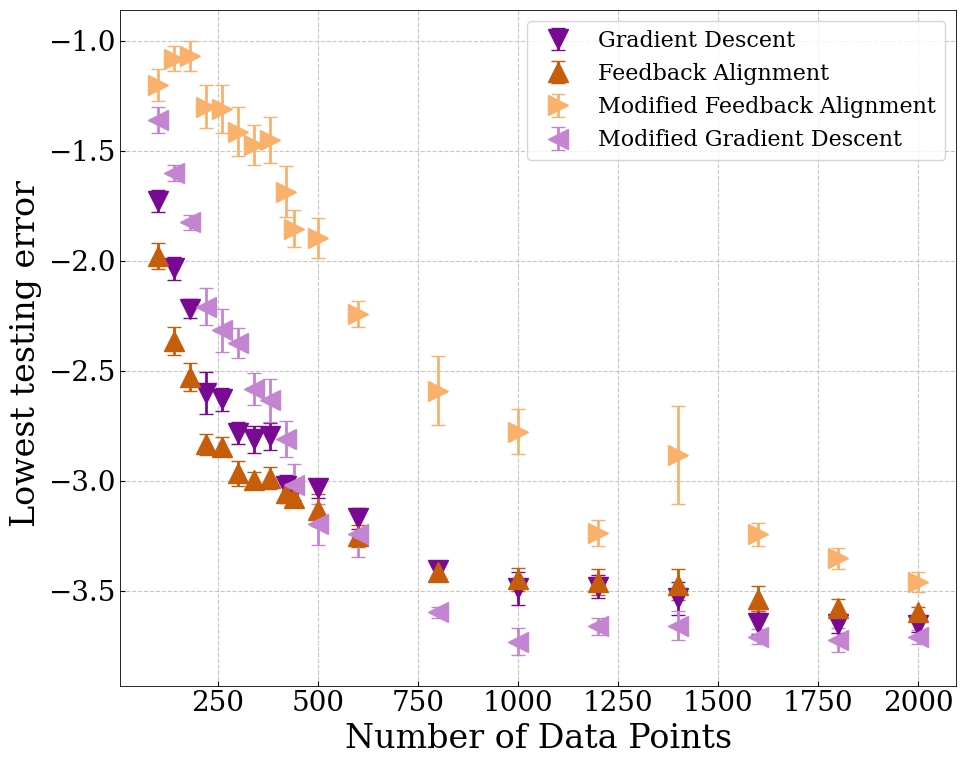

In [47]:
label_list_mod = ['Gradient Descent', 'Feedback Alignment', 'Modified Feedback Alignment', 'Modified Gradient Descent']
fmt_list = ['v','^','>','<']

# Assuming label_list, nb_datpoints_list, err_nbdat_mean, err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

for i, label in enumerate(label_list_mod):
    plt.errorbar(nb_datpoints_list, test_besterror_mean[i, :], yerr=test_besterror_std[i, :] / np.sqrt(nb_init),
                 fmt=fmt_list[i], color=color_list[i], label=label, capsize=5, elinewidth=2, markersize=14)
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth =2)

#plt.yscale('log')

plt.ylabel('Lowest testing error ', fontsize=24)
plt.xlabel('Number of Data Points', fontsize=24)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
plt.legend(fontsize=16, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.ylim(-36,2)
plt.tick_params(axis='both', which='major', labelsize=20)
# Uncomment the following line if you want to save the figure
#plt.savefig('tanh_test_besterror_sini.pdf', dpi=300, bbox_inches='tight')

plt.show()